In [156]:
import pandas as pd
import numpy as np
import re
import json
import functools
import seaborn as sns
import scipy
import collections
import itertools
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
import statsmodels.tsa.stattools as ts
import matplotlib.pyplot as plt
import matplotlib as mpl
from tqdm import tqdm
from scipy.stats import kstest

In [132]:
import warnings
warnings.filterwarnings('ignore')

### Try to parse the updated mean_edge and std_edge from r3_final, however it's hard to handle the log text file

In [33]:
def extract_dicts(raw_text, key):
    # Define the pattern to match the desired section containing the specified key
    pattern = rf'\"{key}\\":\[({{(?:[^{{}}]|(?1))*}})\]'
    
    # Find all matches of the pattern in the raw text
    matches = re.findall(pattern, raw_text)
    
    # Parse each match as a JSON object and append to the list
    extracted_dicts = []
    for match in matches:
        extracted_dict = json.loads("{" + match + "}")
        extracted_dicts.append(extracted_dict)
    
    return extracted_dicts

In [44]:
def extract_dicts(raw_text, key="GIFT_BASKET"):
    # Use regular expression to find the dictionary associated with the specified key
    pattern = r'"{key}":(\[[^\\]]+\\])'
    match = re.search(pattern, raw_text)
    if match:
        # Extract the matched dictionary string and parse it as JSON
        dict_str = match.group(1)
        return json.loads(dict_str)
    else:
        return None

In [37]:
this_line_lst = []
with open('../round3/r3_final.log', 'r') as fp:
    for i in range(10):
        line = next(fp).strip()
        if line[1:10]=="lambdaLog":
            #this_line_lst.append(extract_dicts(line[14:-1], key="GIFT_BASKET"))
            this_line_lst.append(line[14:-1])

In [38]:
this_line_lst

['[[0,\\"\\",[[\\"STARFRUIT\\",\\"STARFRUIT\\",1],[\\"AMETHYSTS\\",\\"AMETHYSTS\\",1],[\\"CHOCOLATE\\",\\"CHOCOLATE\\",1],[\\"GIFT_BASKET\\",\\"GIFT_BASKET\\",1],[\\"ORCHIDS\\",\\"ORCHIDS\\",1],[\\"ROSES\\",\\"ROSES\\",1],[\\"STRAWBERRIES\\",\\"STRAWBERRIES\\",1]],{\\"AMETHYSTS\\":[{\\"9996\\":2,\\"9995\\":25},{\\"10004\\":-2,\\"10005\\":-25}],\\"CHOCOLATE\\":[{\\"7750\\":117},{\\"7752\\":-117}],\\"GIFT_BASKET\\":[{\\"69548\\":2,\\"69547\\":14,\\"69546\\":30},{\\"69559\\":-2,\\"69560\\":-14,\\"69561\\":-30}],\\"ORCHIDS\\":[{\\"1090\\":7,\\"1089\\":2,\\"1082\\":46},{\\"1099\\":-7,\\"1100\\":-2,\\"1108\\":-46}],\\"ROSES\\":[{\\"14415\\":72},{\\"14416\\":-72}],\\"STARFRUIT\\":[{\\"5002\\":1,\\"5001\\":27},{\\"5008\\":-27}],\\"STRAWBERRIES\\":[{\\"3984\\":181},{\\"3986\\":-181}]},[],[],{},[{},{\\"ORCHIDS\\":[1094.0,1095.5,1.5,10.5,-2.0,2000.0,75.0]}]],[[\\"AMETHYSTS\\",9997,20],[\\"AMETHYSTS\\",10003,-20],[\\"STARFRUIT\\",5003,20],[\\"STARFRUIT\\",5007,-20],[\\"GIFT_BASKET\\",69559,37],[\\

In [45]:
extract_dicts(this_line_lst[0])

In [5]:
gift_basket_components_mid_price_lst = []
with open('../round3/r3_final.log', 'r') as fp:
    for line in fp:
        print(line)
        if line[1:10]=="lambdaLog":
            gift_basket_components_mid_price_lst.append(line[14:-1])


In [6]:
len(gift_basket_components_mid_price_lst)

0

### read the r4 historical prices

In [99]:
prices_day_1_df = pd.read_csv('../data/round-4-island-data-bottle/prices_round_4_day_1.csv', index_col='timestamp', sep=';')
prices_day_2_df = pd.read_csv('../data/round-4-island-data-bottle/prices_round_4_day_2.csv', index_col='timestamp', sep=';')
prices_day_3_df = pd.read_csv('../data/round-4-island-data-bottle/prices_round_4_day_3.csv', index_col='timestamp', sep=';')

In [100]:
prices_day_1_df.head()

,day,product,bid_price_1,bid_volume_1,bid_price_2,bid_volume_2,bid_price_3,bid_volume_3,ask_price_1,ask_volume_1,ask_price_2,ask_volume_2,ask_price_3,ask_volume_3,mid_price,profit_and_loss
timestamp,,,,,,,,,,,,,,,,
0,1,COCONUT,9999,200,NaN,NaN,NaN,NaN,10001,200,NaN,NaN,NaN,NaN,10000.0,0.0
0,1,COCONUT_COUPON,637,39,NaN,NaN,NaN,NaN,638,39,NaN,NaN,NaN,NaN,637.5,0.0
100,1,COCONUT,9999,104,9998.0,44.0,NaN,NaN,10000,104,10001.0,44.0,NaN,NaN,9999.5,0.0
100,1,COCONUT_COUPON,637,33,NaN,NaN,NaN,NaN,638,33,NaN,NaN,NaN,NaN,637.5,0.0
200,1,COCONUT,9998,133,9997.0,62.0,NaN,NaN,9999,133,10000.0,62.0,NaN,NaN,9998.5,0.0


In [101]:
Data_df = pd.concat([prices_day_1_df,prices_day_2_df,prices_day_3_df],axis = 0)

In [102]:
df_coconut_day_123 = Data_df.loc[Data_df['product']=='COCONUT'].rename(columns={'mid_price': 'coconut_mid_price'})[['day', 'coconut_mid_price']]
df_coupon_day_123 = Data_df.loc[Data_df['product']=='COCONUT_COUPON'].rename(columns={'mid_price': 'coupon_mid_price'})[['day', 'coupon_mid_price']]


In [103]:
df_all_mid_prices_day_123 = functools.reduce(lambda left, right: pd.merge(left, right, on=['timestamp', 'day']), 
                                                                                [df_coconut_day_123, df_coupon_day_123])

In [104]:
df_all_mid_prices_day_123.head()

,day,coconut_mid_price,coupon_mid_price
timestamp,,,
0,1,10000.0,637.5
100,1,9999.5,637.5
200,1,9998.5,637.5
300,1,9999.5,638.5
400,1,9998.5,637.5


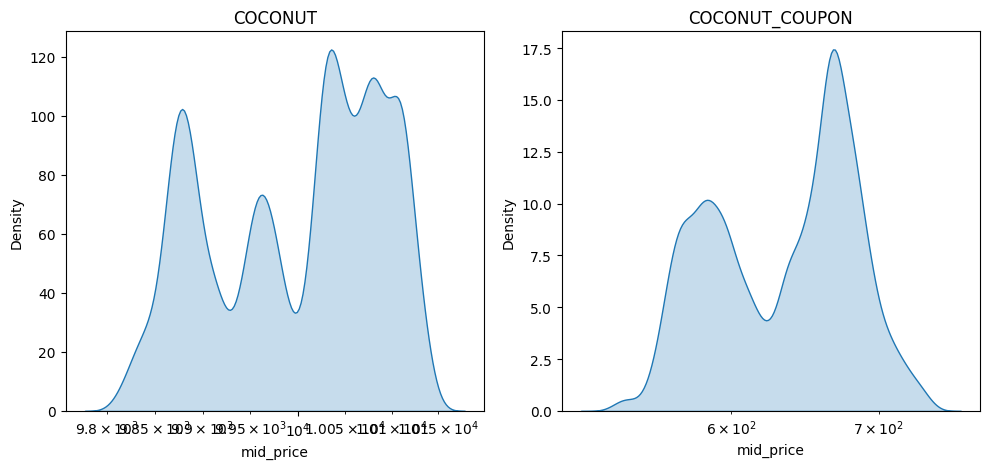

In [54]:
#kde plots
features = Data_df['product'].unique().tolist()
n_cols = 2
n_rows = (len(features) + n_cols - 1) // n_cols
fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 5 * n_rows))
#fig.suptitle('Cumulative Distribution Functions for Each Feature')
axes = axes.ravel()
for i, feature in enumerate(features):
    sns.kdeplot(Data_df.loc[Data_df['product']==feature]['mid_price'], log_scale=True, fill=True, ax=axes[i])
    axes[i].set_title(f'{feature}')
    #axes[i].set_xlabel('Value')
    #axes[i].set_ylabel('Probability')
# Turn off any unused subplots
for j in range(i + 1, len(axes)):
    axes[j].axis('off')
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

In [56]:
df_all_mid_prices_day_123[['coconut_mid_price', 'coupon_mid_price']].corr()

,coconut_mid_price,coupon_mid_price
coconut_mid_price,1.000000,0.957869
coupon_mid_price,0.957869,1.000000


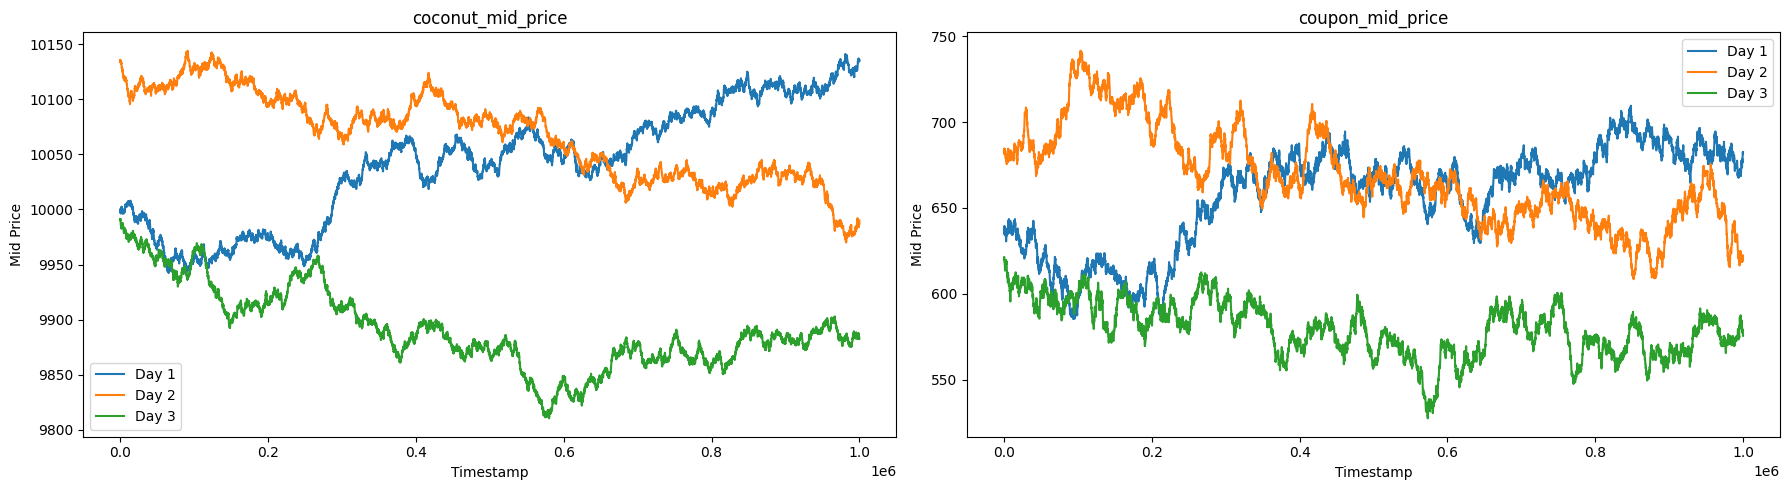

In [58]:
#Feature plots
features = ['coconut_mid_price', 'coupon_mid_price']
n_features = len(features)
n_cols = 2  # Choose 1 column for a vertical layout
n_rows = n_features // n_cols + (n_features % n_cols > 0)
#n_rows = 1
# Create a figure and a set of subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 5 * n_rows))  # Adjust figure size as needed
# Flatten the axes array and iterate over it along with the features
#axes = axes.flatten() if n_rows > 1 else [axes]


for feature, ax in zip(features, axes.flatten()):
    for day in [1, 2, 3]:
        ax.plot(df_all_mid_prices_day_123[df_all_mid_prices_day_123.day == day].index,
                df_all_mid_prices_day_123[df_all_mid_prices_day_123.day == day][feature], label=f'Day {day}')
    ax.set_title(f'{feature}')
    ax.set_xlabel('Timestamp')
    ax.set_ylabel('Mid Price')
    ax.legend()

plt.tight_layout()
plt.show()

In [63]:
coconut_prices_3days_arr = df_coconut_day_123.coconut_mid_price.values
# passing the extracted passengers count to adfuller function.
# result of adfuller function is stored in a res variable
res = adfuller(coconut_prices_3days_arr)
 
# Printing the statistical result of the adfuller test
print('Augmneted Dickey_fuller Statistic - coconut: %f' % res[0])
print('p-value: %f' % res[1])
 
# printing the critical values at different alpha levels.
print('critical values at different levels:')
for k, v in res[4].items():
    print('\t%s: %.3f' % (k, v))

Augmneted Dickey_fuller Statistic - coconut: -0.523799
p-value: 0.887288
critical values at different levels:
	1%: -3.431
	5%: -2.862
	10%: -2.567


In [64]:
coupon_prices_3days_arr = df_coupon_day_123.coupon_mid_price.values
# passing the extracted passengers count to adfuller function.
# result of adfuller function is stored in a res variable
res = adfuller(coupon_prices_3days_arr)
 
# Printing the statistical result of the adfuller test
print('Augmneted Dickey_fuller Statistic - coupon: %f' % res[0])
print('p-value: %f' % res[1])
 
# printing the critical values at different alpha levels.
print('critical values at different levels:')
for k, v in res[4].items():
    print('\t%s: %.3f' % (k, v))

Augmneted Dickey_fuller Statistic - coupon: -1.861315
p-value: 0.350473
critical values at different levels:
	1%: -3.431
	5%: -2.862
	10%: -2.567


### As shown above, both series are non-stationary, they have a very strong correlation

In [65]:
print(f'cointegration test on coconut_mid_price, coupon_mid_price\n')
this_test = ts.coint(df_all_mid_prices_day_123['coconut_mid_price'], df_all_mid_prices_day_123['coupon_mid_price'])
print(f'p_value: {this_test[1]}')
print(this_test)

cointegration test on coconut_mid_price, coupon_mid_price

p_value: 7.055839982389328e-07
(-6.1660473794704975, 7.055839982389328e-07, array([-3.89680511, -3.33633368, -3.04459138]))


In [66]:
print(f'cointegration test on coupon_mid_price, coconut_mid_price\n')
this_test = ts.coint(df_all_mid_prices_day_123['coupon_mid_price'], df_all_mid_prices_day_123['coconut_mid_price'])
print(f'p_value: {this_test[1]}')
print(this_test)

cointegration test on coupon_mid_price, coconut_mid_price

p_value: 1.7164617278287766e-07
(-6.440746508016365, 1.7164617278287766e-07, array([-3.89680511, -3.33633368, -3.04459138]))


### strong co-integration relation exists

In [130]:
# defines a function to perform rolling forecasts with a ECM and intakes a y_var as a string
# X_vars as a list, lr_X_vars as a list, and the rest of the inputs are dataframes, with lr_
# indicating level variables used to estimate the long-run relationship, and diff_ representing
# differenced data
def roll_forecast_ecm(y_var, X_vars, lr_X_vars, lr_train, lr_test, diff_train, diff_test):
    
    # creates two new dataframes that will be added to as the forecast rolls 
    history = lr_train
    diff_history = diff_train
    
    # estimates a linear model to predict the longrun relationship
    lr_model_train = sm.OLS(history[[y_var]], history[lr_X_vars])
    # fits the lr model
    lr_model_train_fit = lr_model_train.fit(cov_type='HC0')
    # adds a disequilibrium column for the training period
    diff_train['disequilibrium'] = lr_model_train_fit.resid.shift(1)
    
    
    # this chunk of data does one-step ahead predictions of the disequilibrium    
    
    # creates an empty list that will hold the residuals for the next period
    disequilibrium = []
    
    # loops through the indexes of the set being forecasted
    for i in tqdm(range(len(lr_test))):
        
        # estimates a linear model to predict the longrun relationship
        # .replace([np.inf, -np.inf], np.nan).fillna(0)
        lr_model = sm.OLS(history[[y_var]]
                          , history[lr_X_vars])
        # fits the lr model
        lr_model_fit = lr_model.fit(cov_type='HC0')
        # forecasts the disequilibrium in the next period and appends it to the list by predicting 
        # the closing price using the 1st lagged value of the independent variable at t+1, which makes it
        # at time t, and subtracting the closing price at time t, giving the residual for time t, which is 
        # t - 1 for the future value we want to predict
        disequilibrium_hat = (float(lr_model_fit.predict(history[-1:][lr_X_vars]))
                             - float(history[-1:][y_var].values))
        disequilibrium.append(disequilibrium_hat)
        # grabs the observation at the ith index
        obs = lr_test[i : i + 1]
        #print(f'obs: {obs}')
        #print(f'history.tail(): {history.tail()}')
        
        # appends the observation to the estimation data set
        #history = history.append(obs)
        #return history, obs
        history = pd.concat([history, obs])
        
    # creates a column of the lagged disequilibrium values
    diff_test['disequilibrium'] = disequilibrium
    
    
    # this chunk of code does the 1-step ahead ECM estimation and prediction
    
    predictions = []
    
    # this list will store the error_correction coefficients  
    error_correction_coefficients = []
    # this list stores the standard error of the EC coefficients
    error_correction_coef_stderr = []

        
    # loops through the indexes of the set being forecasted
    for i in tqdm(range(len(diff_test))):
        
        # estimates an ECM to predict future values
        ecm_model = sm.OLS(diff_history[[y_var]].fillna(0)
                           , diff_history[X_vars].fillna(0))
        # fits the ECM
        ecm_model_fit = ecm_model.fit(cov_type='HC0')
        # predicts the future closing price change and appends it to the list of predictions
        delta_y_hat = float(ecm_model_fit.predict(diff_test[i : i + 1][X_vars]))
        predictions.append(delta_y_hat)
        # grabs the observation at the ith index
        obs = diff_test[i : i + 1]
        # appends the observation to the estimation data set
        #diff_history = diff_history.append(obs)
        diff_history = pd.concat([diff_history, obs])
        
        # appends the error_correction coefficient to the list  
        error_correction_coefficients.append(ecm_model_fit.params.disequilibrium)
        error_correction_coef_stderr.append(ecm_model_fit.HC0_se.disequilibrium)
    
    # adds columns for our lists
    diff_test['delta_y_hat'] = predictions     
    diff_test['ec_coef'] = error_correction_coefficients
    diff_test['ec_stderr'] = error_correction_coef_stderr
    
    # returns predictions
    return (diff_test, ecm_model_fit, disequilibrium) 

### try to use coconut to predict coupon

In [105]:
new_index = "timestamp_" + df_all_mid_prices_day_123.index.astype(str) + "_day_" + df_all_mid_prices_day_123['day'].astype(str)
df_all_mid_prices_day_123.index = new_index

In [118]:
# adds a constant term
X_train_coconut = df_all_mid_prices_day_123[(df_all_mid_prices_day_123.day==1) 
                                             | (df_all_mid_prices_day_123.day==2)][['coconut_mid_price']]
X_train_coconut = sm.add_constant(X_train_coconut)
X_test_coconut = df_all_mid_prices_day_123[df_all_mid_prices_day_123.day==3][['coconut_mid_price']]

y_train_coupon = df_all_mid_prices_day_123[(df_all_mid_prices_day_123.day==1) 
                                             | (df_all_mid_prices_day_123.day==2)]['coupon_mid_price']
y_test_coupon = df_all_mid_prices_day_123[df_all_mid_prices_day_123.day==3][['coupon_mid_price']]
# estimates a linear regression of roses_mid_price ~ const + chocolate_mid_price
lr_model = sm.OLS(y_train_coupon, X_train_coconut)
lr_model_fit = lr_model.fit(cov_type='HC0')

# prints a summary
print(lr_model_fit.summary())

                            OLS Regression Results                            
Dep. Variable:       coupon_mid_price   R-squared:                       0.755
Model:                            OLS   Adj. R-squared:                  0.755
Method:                 Least Squares   F-statistic:                 5.427e+04
Date:                Fri, 19 Apr 2024   Prob (F-statistic):               0.00
Time:                        15:35:25   Log-Likelihood:                -81578.
No. Observations:               20000   AIC:                         1.632e+05
Df Residuals:                   19998   BIC:                         1.632e+05
Df Model:                           1                                         
Covariance Type:                  HC0                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const             -4519.6288     22.24

### since the two prices are co-integrated, print spread based on regression results

<Axes: ylabel='Density'>

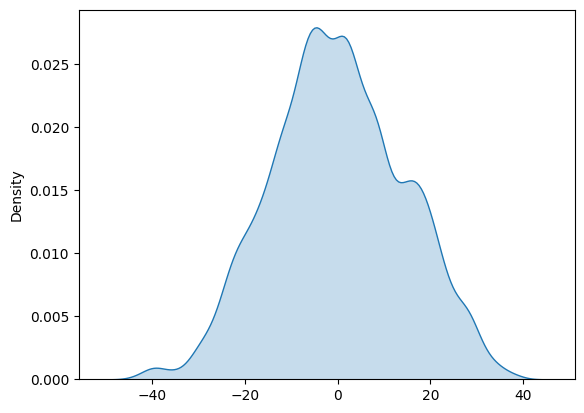

In [155]:
sns.kdeplot(lr_model_fit.resid, fill=True)

In [157]:
#perform Kolmogorov-Smirnov test for normality
kstest(lr_model_fit.resid, 'norm')

KstestResult(statistic=0.44199649718622913, pvalue=0.0, statistic_location=-2.266725402361317, statistic_sign=1)

In [158]:
# ADF test on the residuals, which has to be stationary 
# “c” : constant only (default).
# “ct” : constant and trend.
# “ctt” : constant, and linear and quadratic trend.
# “n” : no constant, no trend.

for i in ['c', 'ct', 'ctt', 'n']:
    result = adfuller(lr_model_fit.resid, regression = i)
    print('ADF Statistic with %s for Closing X_train_chocolate price: %f' % (i, result[0]))
    print('p-value: %f\n' % result[1])

ADF Statistic with c for Closing X_train_chocolate price: -4.889257
p-value: 0.000037

ADF Statistic with ct for Closing X_train_chocolate price: -5.000329
p-value: 0.000205

ADF Statistic with ctt for Closing X_train_chocolate price: -5.011439
p-value: 0.000981

ADF Statistic with n for Closing X_train_chocolate price: -4.889382
p-value: 0.000002



In [145]:
lr_model_fit.params

const               -4519.628771
coconut_mid_price       0.515453
dtype: float64

In [150]:
#spread = y - x*beta - alpha
Xy_train_coconut_coupon_df = X_train_coconut.join(y_train_coupon)

In [151]:
Xy_train_coconut_coupon_df['spread'] = Xy_train_coconut_coupon_df['coupon_mid_price'] - (lr_model_fit.params[0] + lr_model_fit.params[1] * Xy_train_coconut_coupon_df['coconut_mid_price'])

In [152]:
Xy_train_coconut_coupon_df.head()

,const,coconut_mid_price,coupon_mid_price,spread
timestamp_0_day_1,1.0,10000.0,637.5,2.598120
timestamp_100_day_1,1.0,9999.5,637.5,2.855846
timestamp_200_day_1,1.0,9998.5,637.5,3.371300
timestamp_300_day_1,1.0,9999.5,638.5,3.855846
timestamp_400_day_1,1.0,9998.5,637.5,3.371300


In [153]:
Xy_train_coconut_coupon_df.spread.mean(), Xy_train_coconut_coupon_df.spread.std()

(-2.694814611459151e-11, 14.296134677216813)

### trading signal - Here we use X(adjustable param)  times the standard deviation as our threshold. If the sample is out of this range, then we think there is a price divergence between these two stocks price which means we capture a pairs trading opportunity. 
### ema of the history price over 250 days(adjustable param) is used to perform the regression.

### get sperad std for the historical 3 days

In [159]:
# adds a constant term
X_train_coconut_3days = df_all_mid_prices_day_123[(df_all_mid_prices_day_123.day==1) 
                                             | (df_all_mid_prices_day_123.day==2)
                                             | (df_all_mid_prices_day_123.day==3)][['coconut_mid_price']]
X_train_coconut_3days = sm.add_constant(X_train_coconut_3days)

y_train_coupon_3days = df_all_mid_prices_day_123[(df_all_mid_prices_day_123.day==1) 
                                             | (df_all_mid_prices_day_123.day==2)
                                             | (df_all_mid_prices_day_123.day==3)]['coupon_mid_price']
# estimates a linear regression of roses_mid_price ~ const + chocolate_mid_price
lr_model_3days = sm.OLS(y_train_coupon_3days, X_train_coconut_3days)
lr_model_fit_3days = lr_model_3days.fit(cov_type='HC0')

# prints a summary
print(lr_model_fit_3days.summary())

                            OLS Regression Results                            
Dep. Variable:       coupon_mid_price   R-squared:                       0.918
Model:                            OLS   Adj. R-squared:                  0.918
Method:                 Least Squares   F-statistic:                 3.604e+05
Date:                Fri, 19 Apr 2024   Prob (F-statistic):               0.00
Time:                        16:19:34   Log-Likelihood:            -1.2038e+05
No. Observations:               30000   AIC:                         2.408e+05
Df Residuals:                   29998   BIC:                         2.408e+05
Df Model:                           1                                         
Covariance Type:                  HC0                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const             -4393.5047      8.35

In [160]:
#perform Kolmogorov-Smirnov test for normality
kstest(lr_model_fit_3days.resid, 'norm')

KstestResult(statistic=0.4420692531002327, pvalue=0.0, statistic_location=-2.3044958127027257, statistic_sign=1)

In [161]:
# ADF test on the residuals, which has to be stationary 
# “c” : constant only (default).
# “ct” : constant and trend.
# “ctt” : constant, and linear and quadratic trend.
# “n” : no constant, no trend.

for i in ['c', 'ct', 'ctt', 'n']:
    result = adfuller(lr_model_fit_3days.resid, regression = i)
    print('ADF Statistic with %s for Closing X_train_chocolate price: %f' % (i, result[0]))
    print('p-value: %f\n' % result[1])

ADF Statistic with c for Closing X_train_chocolate price: -6.440639
p-value: 0.000000

ADF Statistic with ct for Closing X_train_chocolate price: -6.468695
p-value: 0.000000

ADF Statistic with ctt for Closing X_train_chocolate price: -6.525373
p-value: 0.000001

ADF Statistic with n for Closing X_train_chocolate price: -6.440747
p-value: 0.000000



In [162]:
#spread = y - x*beta - alpha
Xy_train_coconut_coupon_df_3days = X_train_coconut_3days.join(y_train_coupon_3days)

In [163]:
Xy_train_coconut_coupon_df_3days['spread'] = Xy_train_coconut_coupon_df_3days['coupon_mid_price'] - (lr_model_fit_3days.params[0] + lr_model_fit_3days.params[1] * Xy_train_coconut_coupon_df_3days['coconut_mid_price'])

In [164]:
Xy_train_coconut_coupon_df_3days.spread.mean(), Xy_train_coconut_coupon_df_3days.spread.std()

(1.0972265348148842e-11, 13.381985335999802)

In [165]:
Xy_train_coconut_coupon_df_3days.spread.max()

41.7862537351557

In [167]:
Xy_train_coconut_coupon_df_3days.coconut_mid_price.mean(), Xy_train_coconut_coupon_df_3days.coupon_mid_price.mean()

(9999.900983333333, 635.0464333333333)

### Use 13.38 as initial threshold of spread std, use 0 as initial spread mean then in each round:
* do ema update on coupon_mid_price & coconut_mid_price, call it ema_coupon_mid_price, ema_coconut_mid_price
* regress ema_coupon_mid_price over ema_coconut_mid_price, call it lr_fit_new model
* update spread based on ema_coupon_mid_price - (lr_fit_new.params[0]+lr_fit_new.params[1]*ema_coconut_mid_price)
* update spread mean & std
* adjust ema period and strategy triggered level on spread std

### As shown below, ECM is not performing well, use the spread strategy above instead

### The error-correction term in the ECM must be negative. The lagged residuals from the linear regression represent the deviation from the long-run relationship in the previous period.
### The intuition is if our stock price is above its long-run equilibrium with the market, the negative coefficient pulls it back down. If it is below the long-run equilibrium, the negatives will cancel out and become positive pulling the stock price back up. That is the magic of the ECM.

### Regression results looks good, all ADF tests are significant

In [76]:
df_all_mid_prices_day_123.head()

,day,coconut_mid_price,coupon_mid_price
timestamp_0_day_1,1,10000.0,637.5
timestamp_100_day_1,1,9999.5,637.5
timestamp_200_day_1,1,9998.5,637.5
timestamp_300_day_1,1,9999.5,638.5
timestamp_400_day_1,1,9998.5,637.5


In [77]:
len(df_all_mid_prices_day_123), len(lr_model_fit.resid)

(30000, 20000)

In [136]:
diff_train_coconut = X_train_coconut.copy()
diff_train_coconut = diff_train_coconut.join(y_train_coupon)
diff_train_coconut['coupon_mid_price'] = diff_train_coconut['coupon_mid_price'].diff()
diff_train_coconut['coconut_mid_price'] = diff_train_coconut['coconut_mid_price'].diff()
#diff_train_coconut = diff_train_coconut.join(df_all_mid_prices_day_123['disequilibrium'])

diff_train_coconut = diff_train_coconut.dropna()

In [137]:
diff_train_coconut.head()

,const,coconut_mid_price,coupon_mid_price
timestamp_100_day_1,1.0,-0.5,0.0
timestamp_200_day_1,1.0,-1.0,0.0
timestamp_300_day_1,1.0,1.0,1.0
timestamp_400_day_1,1.0,-1.0,-1.0
timestamp_500_day_1,1.0,-2.0,0.0


In [138]:
diff_test_coconut = X_test_coconut.copy()
diff_test_coconut = diff_test_coconut.join(y_test_coupon)
diff_test_coconut['coupon_mid_price'] = diff_test_coconut['coupon_mid_price'].diff()
diff_test_coconut['coconut_mid_price'] = diff_test_coconut['coconut_mid_price'].diff()
diff_test_coconut = sm.add_constant(diff_test_coconut)

In [139]:
diff_test_coconut.head()

,const,coconut_mid_price,coupon_mid_price
timestamp_0_day_3,1.0,NaN,NaN
timestamp_100_day_3,1.0,-1.0,0.5
timestamp_200_day_3,1.0,0.5,0.0
timestamp_300_day_3,1.0,1.0,1.0
timestamp_400_day_3,1.0,-1.5,0.0


In [127]:
# predictors = ['coconut_mid_price'
#              , 'disequilibrium', 'const']
# diff_train_coconut['disequilibrium'] = lr_model_fit.resid
# diff_train_coconut.disequilibrium = diff_train_coconut.disequilibrium.shift(1).fillna(0)
# ecm_train = sm.OLS(diff_train_coconut['coupon_mid_price'], diff_train_coconut[predictors])
# ecm_train_fit = ecm_train.fit(cov_type='HC0')

# # prints a summary
# print(ecm_train_fit.summary())

                            OLS Regression Results                            
Dep. Variable:       coupon_mid_price   R-squared:                       0.205
Model:                            OLS   Adj. R-squared:                  0.205
Method:                 Least Squares   F-statistic:                     2647.
Date:                Fri, 19 Apr 2024   Prob (F-statistic):               0.00
Time:                        15:38:08   Log-Likelihood:                -29614.
No. Observations:               19999   AIC:                         5.923e+04
Df Residuals:                   19996   BIC:                         5.926e+04
Df Model:                           2                                         
Covariance Type:                  HC0                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
coconut_mid_price     0.5211      0.00

In [140]:
predictors = ['coconut_mid_price', 'disequilibrium', 'const']
(y_var, X_vars, lr_X_vars, lr_train, lr_test, diff_train, diff_test) = ('coupon_mid_price', 
                                                                        predictors, 
                                                                        ['coconut_mid_price'], 
                                                                        X_train_coconut.join(y_train_coupon), 
                                                                        X_test_coconut.join(y_test_coupon), 
                                                                        diff_train_coconut.fillna(0), 
                                                                        diff_test_coconut.fillna(0)) 

In [141]:
ecm_results = roll_forecast_ecm(y_var, X_vars, lr_X_vars, lr_train, lr_test, diff_train, diff_test)

100%|██████████| 10000/10000 [01:27<00:00, 114.41it/s]


In [142]:
print('Mean Absolute Error over Test Data Set: ' + 
      str(sum(abs(ecm_results[0][y_var] - ecm_results[0].delta_y_hat)) / len(ecm_results[0])))

Mean Absolute Error over Test Data Set: 0.8425274743501022


In [143]:
print(ecm_results[1].summary())

                            OLS Regression Results                            
Dep. Variable:       coupon_mid_price   R-squared:                       0.193
Model:                            OLS   Adj. R-squared:                  0.192
Method:                 Least Squares   F-statistic:                     3661.
Date:                Fri, 19 Apr 2024   Prob (F-statistic):               0.00
Time:                        15:51:34   Log-Likelihood:                -44383.
No. Observations:               29998   AIC:                         8.877e+04
Df Residuals:                   29995   BIC:                         8.880e+04
Df Model:                           2                                         
Covariance Type:                  HC0                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
coconut_mid_price     0.5040      0.00